# **Model Testing** - Final Predictive Model All Features

**All Features:**

Data columns (total 29 columns):

Specific Identifiers:

- BillID      51067 non-null object


How far it made it:

- PassH       51067 non-null int64
- PassS       51067 non-null int64
- PLawDate    1393 non-null object - MAKE BOOL?
- PLawNum     51067 non-null object
- PLaw        51067 non-null int64
- Veto        51067 non-null int64

Bill Descriptive Info:

- BillType    51067 non-null object
- Title       51067 non-null object
- Cong        51067 non-null int64
- Summary     51017 non-null object - REMOVE NULL
- ImpBill     51067 non-null int64
- Chamber     51067 non-null int64 (H or S)

Info about Rep Bill Proposer:

- Cosponsr    51067 non-null float64
- IntrDate    51025 non-null object - REMOVE NULL
- Mult        51067 non-null int64
- Class       51067 non-null float64
- District    51067 non-null float64
- FrstConH    51067 non-null float64
- FrstConS    51067 non-null float64
- Gender      51067 non-null int64
- MRef        51067 non-null int64
- NameFull    51067 non-null object
- Party       51067 non-null float64
- Postal      51067 non-null object
- Majority    51067 non-null int64

Other general bill info:

- Major       51067 non-null float64
- Minor       51067 non-null float64

The URL:

- URL         51067 non-null object


List of the models to test and the parameters to tune:
  
**Models:**
- Naive Bayes
- Logistic Regression
- Random Forest
- SVM

**Evaluations:**
- Accuracy, precision, recall, f1
- Confusion Matrix
- ROC/AUC

**Class Imbalance Issues:**
- Run a model on just one topic with good class distribution:
- Undersampling
- Use top 10 words for each PassH as features


- try running models with only words
- ADD top five pass, top five not pass


- try one without 112th
    

In [8]:
! pip install sklearn-pandas

# **Query Data**

In [281]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db

import config_final as config
from schema import DbSchema



In [282]:
bills_db = DbSchema(config)


In [283]:
#Full dataframe for running models

df = bills_db.query("""
    SELECT cb.BillID, 
        cb.Chamber,
        cb.IntrDate,
        cb.Title, 
        cb.Cosponsr, 
        cb.Mult,
        cb.District,
        cb.FrstConH,
        cb.Gender,
        cb.NameFull,
        cb.Party,
        cb.Postal,
        cb.PassH,
        cb.Majority,
        tp.dominant_topic         
    FROM 
        con_bills.current_bills as cb
    JOIN
        con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >= 110""")


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51067 entries, 0 to 51066
Data columns (total 15 columns):
BillID            51067 non-null object
Chamber           51067 non-null int64
IntrDate          51025 non-null object
Title             51067 non-null object
Cosponsr          51067 non-null float64
Mult              51067 non-null int64
District          51067 non-null float64
FrstConH          51067 non-null float64
Gender            51067 non-null int64
NameFull          51067 non-null object
Party             51067 non-null float64
Postal            51067 non-null object
PassH             51067 non-null int64
Majority          51067 non-null int64
dominant_topic    51067 non-null int64
dtypes: float64(4), int64(6), object(5)
memory usage: 5.8+ MB


In [285]:
df['IntrDate'].isnull().sum()

42

# **Final Data Cleaning**

Add:
- Len title words or anything?
- tfidf on title?

REMOVE:
- PLawNum (not necessary for analysis)
- Major/Minor (no keys)
- PLawDate (too few)
- ImpBill (almost all are)


Edit: 
- BillType: 
- Chamber: To binary
- Cong: OHE
- Postal: OHE

How to deal with: Things that happen after House passage!?

In [289]:
df.isnull().sum()

BillID             0
Chamber            0
IntrDate          42
Title              0
Cosponsr           0
Mult               0
District           0
FrstConH           0
Gender             0
NameFull           0
Party              0
Postal             0
PassH              0
Majority           0
dominant_topic     0
dtype: int64

In [290]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [291]:
#Replace Nulls in IntrDate - Figure out how to do this!
#Maybe change to just month or just year
# df['IntrDate'].head()

# **Final Engineering:**

**Engineer Cosponsors:**

Relevant info for cosponsorship: https://fas.org/sgp/crs/misc/RS22477.pdf

- min is 0, max is 432
- total value count is 325
- Big dropoff in count after around 30-40 cosponsors (becomes less than 100 instances)

In [292]:
test=[]
for x in df['Cosponsr']:
    if x == 38.0:
        test.append(x)
        
len(test)

123

In [293]:
def cosponsr_clean(x):
    if x <= 44.0:
        return x
    if x > 44.0:
        return 50
        

In [294]:
def party_clean(x):
    if x == 100.0:
        return 0
    if x == 200.0:
        return 1
    if x == 328.0:
        return 3

In [295]:
def billtype_clean(x):
    if x == 'hr':
        return 0
    if x == 's':
        return 1
     

In [296]:
df.head()

,BillID,Chamber,IntrDate,Title,Cosponsr,Mult,District,FrstConH,Gender,NameFull,Party,Postal,PassH,Majority,dominant_topic
0,110-HR-1,0,2007-01-05 00:00:00,To provide for the implementation of the recom...,205.0,1,2.0,0.0,0,Bennie Thompson,100.0,MS,1,1,5
1,110-HR-10,0,2007-01-04 00:00:00,Reserved for Speaker.,0.0,0,8.0,0.0,1,Nancy Pelosi,100.0,CA,0,1,10
2,110-HR-100,0,2007-01-04 00:00:00,To amend the Higher Education Act of 1965 to p...,10.0,0,53.0,0.0,1,Susan Davis,100.0,CA,0,1,4
3,110-HR-1000,0,2007-02-12 00:00:00,To award a congressional gold medal to Edward ...,286.0,0,0.0,0.0,1,Eleanor Norton,100.0,DC,0,1,10
4,110-HR-1001,0,2007-02-12 00:00:00,To amend the Haitian Hemispheric Opportunity t...,0.0,0,5.0,0.0,0,John Spratt,100.0,SC,0,1,5


In [297]:
def name_clean(x):
    if x >= 400:
        return 1
    if x >= 300 and x <= 399:
        return 2
    if x >= 200 and x <= 299:
        return 3
    if x >= 150 and x <= 199:
        return 4
    if x >=100 and x <= 149:
        return 5
    if x >=50 and x <= 99:
        return 6
    if x < 50:
        return 7

In [298]:
# df['IntrDate'] = df['IntrDate'].fillna(' ', inplace=True)


In [299]:
df['IntrDate'].isnull().sum()

42

In [300]:
df.dropna(subset=['IntrDate'], inplace=True)

In [301]:
df.shape

(51025, 15)

**Add Columns:**

- Add a columns of Title Length. We saw in EDA that title length for passing bills tended to be longer.
- Add cleaned cosponsor column

In [302]:
def final_columns(df):
    
    
    df['month'] = df['IntrDate'].apply(lambda x: x.strftime('%B')) 
    
    names = df['NameFull'].value_counts()

    names_dict = names.to_dict() #converts to dictionary

    df['sponsor_count'] = df['NameFull'].map(names_dict) 
    
    df['title_len'] = [len(summary) for summary in df['Title']]
    
    df['clean_cosponsr'] = df['Cosponsr'].map(lambda x: cosponsr_clean(x))

    df['clean_party'] = df['Party'].map(lambda x: party_clean(x))
    
    df['ranked_sponsor_count'] = df['sponsor_count'].map(lambda x: name_clean(x))
    
    
    df.drop(columns=['Cosponsr', 'Party', 'NameFull', 'sponsor_count', 'Title', 'IntrDate'], inplace=True)
        
    return df

# Finalize Dataframe:

In [303]:
final_df = final_columns(df)

In [304]:
final_df.head()

,BillID,Chamber,Mult,District,FrstConH,Gender,Postal,PassH,Majority,dominant_topic,month,title_len,clean_cosponsr,clean_party,ranked_sponsor_count
0,110-HR-1,0,1,2.0,0.0,0,MS,1,1,5,January,128,50.0,0,6
1,110-HR-10,0,0,8.0,0.0,1,CA,0,1,10,January,21,0.0,0,7
2,110-HR-100,0,0,53.0,0.0,1,CA,0,1,4,January,150,10.0,0,5
3,110-HR-1000,0,0,0.0,0.0,1,DC,0,1,10,February,136,50.0,0,3
4,110-HR-1001,0,0,5.0,0.0,0,SC,0,1,5,February,201,0.0,0,7


In [305]:
final_df['ranked_sponsor_count'].value_counts()

6    15483
7    12814
5     8066
4     6168
3     5591
1     2193
2      710
Name: ranked_sponsor_count, dtype: int64

In [306]:
final_df.shape

(51025, 15)

In [307]:
final_df['PassH'].value_counts()

0    47004
1     4021
Name: PassH, dtype: int64

In [308]:
final_df.isnull().sum()

BillID                  0
Chamber                 0
Mult                    0
District                0
FrstConH                0
Gender                  0
Postal                  0
PassH                   0
Majority                0
dominant_topic          0
month                   0
title_len               0
clean_cosponsr          0
clean_party             0
ranked_sponsor_count    0
dtype: int64

# Undersampling

In [82]:
# example of random undersampling to balance the class distribution
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import RandomUnderSampler

# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')

In [83]:

# fit and apply the transform
# X_over, y_over = undersample.fit_resample(X, y)

In [84]:
# print(Counter(y_over))

In [85]:

# # define pipeline
# steps = [('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())]
# pipeline = Pipeline(steps=steps)

# **X and Y**

In [309]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['PassH'], axis=1)
y = df['PassH']


In [310]:
X.head()


,BillID,Chamber,Mult,District,FrstConH,Gender,Postal,Majority,dominant_topic,month,title_len,clean_cosponsr,clean_party,ranked_sponsor_count
0,110-HR-1,0,1,2.0,0.0,0,MS,1,5,January,128,50.0,0,6
1,110-HR-10,0,0,8.0,0.0,1,CA,1,10,January,21,0.0,0,7
2,110-HR-100,0,0,53.0,0.0,1,CA,1,4,January,150,10.0,0,5
3,110-HR-1000,0,0,0.0,0.0,1,DC,1,10,February,136,50.0,0,3
4,110-HR-1001,0,0,5.0,0.0,0,SC,1,5,February,201,0.0,0,7


**One hot encoding**

All categorical variables:
- 

In [312]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Then One-Hot-Encode:

- Encode categorical integer features using a one-hot aka one-of-K scheme.
- The input to this transformer should be a matrix of integers, denoting the values taken on by categorical (discrete) features.
- The output will be a sparse matrix where each column corresponds to one possible value of one feature.
- It is assumed that input features take on values in the range [0, n_values).
- This encoding is needed for feeding categorical data to many scikit-learn estimators, notably linear models and SVMs with the standard kernels.

# **Modeling**

Import packages:

- CountVectorizer
- TFIDF

- Naive Bayes
- Logistic Regression
- Random Forest

**Remember to look at feature importances!

In [313]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from tokenizer_schema import tokenizer

# We will train our classifier with the following features:

# We create the preprocessing pipelines for all data types.


In [314]:
no_change_features = ['PassH', 'Chamber','Mult', 'Gender', 'Majority']
# no_change_transformer = Pipeline(steps=[
#     ()])

In [315]:
# word_features = ['Title']
# word_transformer = Pipeline(steps=[
#     ('tfidf', CountVectorizer(tokenizer=tokenizer))])

# for adding to preprocessor
# ('word', word_transformer, word_features),

In [316]:
numeric_features = ['clean_cosponsr', 'title_len']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

In [317]:
categorical_features = ['Postal', 'dominant_topic', 'District', 'clean_party', 'FrstConH', 'ranked_sponsor_count', 'month']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [318]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline - laid out for each model below.

In [319]:
preprocessor

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  MinMaxScaler(copy=True,
                                                               feature_range=(0,
                                                                              1)))],
                                          verbose=False),
                                 ['clean_cosponsr', 'title_len']),
                                ('cat',
                                 Pipeline(memory=None,
                                          steps=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                    

**Train test split**

In [321]:
#Train Test split!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=1)

In [322]:
X_train.shape

(40820, 14)

In [323]:
X_train.head()

,BillID,Chamber,Mult,District,FrstConH,Gender,Postal,Majority,dominant_topic,month,title_len,clean_cosponsr,clean_party,ranked_sponsor_count
31737,112-S-629,1,0,0.0,0.0,1,AK,0,1,March,53,9.0,1,3
12578,111-HR-2346,0,0,7.0,0.0,0,WI,1,5,May,105,0.0,0,7
7351,110-S-1008,1,0,0.0,0.0,0,VT,1,1,March,124,1.0,0,4
42299,114-HR-217,0,0,6.0,0.0,1,TN,1,12,January,166,50.0,1,6
11163,111-HR-1072,0,0,18.0,0.0,1,FL,0,5,February,211,2.0,1,5


In [324]:
X_test.shape

(10205, 14)

In [325]:
y_train.shape

(40820,)

In [326]:
y_test.shape

(10205,)

**Naive Bayes**

In [328]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


nb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())]) #get parameters
parameters = None

nb.fit(X_train, y_train)

nb_y_pred = nb.predict(X_test)

print(confusion_matrix(y_test, nb_y_pred))
print(classification_report(y_test, nb_y_pred))

nb_confusion_matrix = (confusion_matrix(y_test, nb_y_pred))

[[9319   23]
 [ 803   60]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9342
           1       0.72      0.07      0.13       863

    accuracy                           0.92     10205
   macro avg       0.82      0.53      0.54     10205
weighted avg       0.90      0.92      0.89     10205



Text(0.5, 1, 'Confusion Matrix')

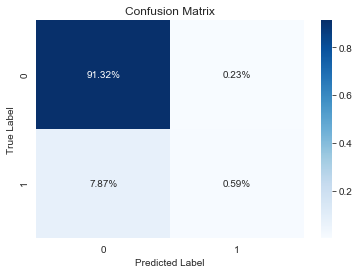

In [329]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(nb_confusion_matrix/np.sum(nb_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

Use Pipeline or DFMapper!

EXAMPLE

# **Logistic Regression**

- Precision means the percentage of your results which are relevant. 
- recall refers to the percentage of total relevant results correctly classified by your algorithm.

Also make a precision recall curve

In [331]:
from sklearn.linear_model import LogisticRegression

# Bring in OHE?

lr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced', C=1, n_jobs=-1))]) #get parameters

# Logistic Regression Classifier
# lr_classifier = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_y_pred = lr_clf.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test, lr_y_pred))

lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

[[6760 2582]
 [ 256  607]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.83      9342
           1       0.19      0.70      0.30       863

    accuracy                           0.72     10205
   macro avg       0.58      0.71      0.56     10205
weighted avg       0.90      0.72      0.78     10205



In [332]:
# Probability estimates.
lr_clf.predict_proba(X_test)

array([[0.42217236, 0.57782764],
       [0.75262621, 0.24737379],
       [0.86401297, 0.13598703],
       ...,
       [0.78668078, 0.21331922],
       [0.88122179, 0.11877821],
       [0.68405307, 0.31594693]])

In [333]:
# Return the mean accuracy on the given test data and labels.
lr_clf.score(X_test, y_test)

0.7219010289073984

Text(0.5, 1, 'Confusion Matrix')

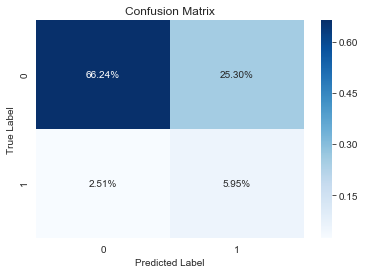

In [334]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(lr_confusion_matrix/np.sum(lr_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

**Testing the predications:**

In [335]:
lr_y_pred[101]

0

In [336]:
y_test.iloc[101]

0

In [337]:
X_test.reset_index()

,index,BillID,Chamber,Mult,District,FrstConH,Gender,Postal,Majority,dominant_topic,month,title_len,clean_cosponsr,clean_party,ranked_sponsor_count
0,23524,112-HR-2636,0,0,42.0,0.0,0,CA,1,9,July,201,7.0,1,7
1,39808,113-S-2628,1,0,0.0,0.0,0,NE,0,0,July,166,0.0,1,7
2,29745,112-S-2180,1,0,0.0,0.0,0,AK,1,10,March,290,0.0,0,4
3,32584,113-HR-1395,0,0,1.0,0.0,1,NV,0,10,March,234,18.0,0,6
4,44420,114-HR-4085,0,0,12.0,0.0,0,OH,1,6,November,116,15.0,1,6
5,17938,111-S-1257,1,0,0.0,1.0,1,WA,1,8,June,261,5.0,0,4
6,21429,111-S-746,1,0,0.0,0.0,0,NE,1,11,March,187,1.0,0,6
7,48687,114-S-2049,1,0,0.0,0.0,0,OH,0,2,September,322,0.0,0,2
8,34172,113-HR-283,0,0,3.0,0.0,0,TN,1,5,January,118,20.0,1,7
9,41296,114-HR-1257,0,0,23.0,0.0,1,FL,0,0,March,155,24.0,0,7


In [249]:
X_test.iloc[101]

BillID                  114-S-687
Chamber                         1
Mult                            0
District                        0
FrstConH                        0
Gender                          0
Postal                         DE
Majority                        0
dominant_topic                  8
month                       March
title_len                      65
clean_cosponsr                  1
clean_party                     0
ranked_sponsor_count            4
Name: 50720, dtype: object

In [250]:
X_test

,BillID,Chamber,Mult,District,FrstConH,Gender,Postal,Majority,dominant_topic,month,title_len,clean_cosponsr,clean_party,ranked_sponsor_count
23524,112-HR-2636,0,0,42.0,0.0,0,CA,1,9,July,201,7.0,1,5
39808,113-S-2628,1,0,0.0,0.0,0,NE,0,0,July,166,0.0,1,5
29745,112-S-2180,1,0,0.0,0.0,0,AK,1,10,March,290,0.0,0,3
32584,113-HR-1395,0,0,1.0,0.0,1,NV,0,10,March,234,18.0,0,4
44420,114-HR-4085,0,0,12.0,0.0,0,OH,1,6,November,116,15.0,1,4
17938,111-S-1257,1,0,0.0,1.0,1,WA,1,8,June,261,5.0,0,3
21429,111-S-746,1,0,0.0,0.0,0,NE,1,11,March,187,1.0,0,4
48687,114-S-2049,1,0,0.0,0.0,0,OH,0,2,September,322,0.0,0,2
34172,113-HR-283,0,0,3.0,0.0,0,TN,1,5,January,118,20.0,1,5
41296,114-HR-1257,0,0,23.0,0.0,1,FL,0,0,March,155,24.0,0,5


**ROC/AUC Curve**

In [251]:
#for ROC/AUC Curve

lr_dec = lr_clf.decision_function(X_test)

In [252]:
import numpy as np
from sklearn.metrics import roc_auc_score
lr_roc_auc = roc_auc_score(y_test, lr_y_pred)
lr_roc_auc

#This is a decent ROC Score. Remember lays between .5 and 1

0.7141828614862593

For ROC/AUC - Edit the threshold, which starts at 0.

Test AUC: 0.7982875775258846


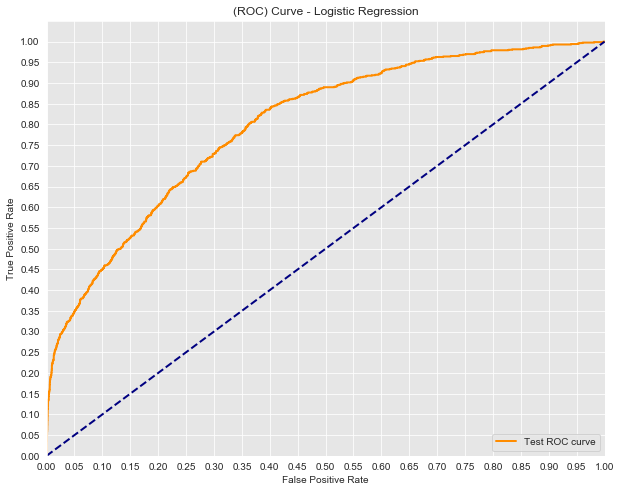

In [253]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, lr_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [254]:
from sklearn.metrics import average_precision_score

lr_average_precision = average_precision_score(y_test, lr_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

Average precision-recall score: 0.38


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.38')

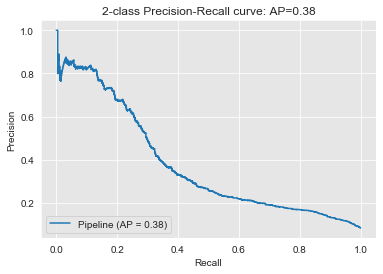

In [255]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(lr_clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(lr_average_precision))

# **SVM Classifier:**

In [ ]:
from sklearn.svm import SVC

svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(class_weight = 'balanced', C=1e5, kernel='linear'))])


svm.fit(X_train, y_train)

svm_y_pred = svm.predict(X_test)

print(confusion_matrix(y_test, svm_y_pred))
print(classification_report(y_test, svm_y_pred))

svm_confusion_matrix = confusion_matrix(y_test, svm_y_pred)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(svm_confusion_matrix/np.sum(svm_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
svm_roc_auc = roc_auc_score(y_test, svm_y_pred)
svm_roc_auc

#This is an okish AUC Score

In [ ]:
svm_dec = svm.decision_function(X_test)

In [ ]:
#AUC/ROC Curve

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, svm_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - SVM Classifier')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score

svm_average_precision = average_precision_score(y_test, svm_dec)

print('Average precision-recall score: {0:0.2f}'.format(
      lr_average_precision))

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(svm, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(svm_average_precision))

# **SGD Classifer**

In [378]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier(loss='log'))])


sgd.fit(X_train, y_train)

sgd_y_pred = sgd.predict(X_test)

print(confusion_matrix(y_test, sgd_y_pred))
print(classification_report(y_test, sgd_y_pred))

sg_confusion_matrix = confusion_matrix(y_test, sgd_y_pred)

[[9346   42]
 [ 690  136]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9388
           1       0.76      0.16      0.27       826

    accuracy                           0.93     10214
   macro avg       0.85      0.58      0.62     10214
weighted avg       0.92      0.93      0.91     10214



Text(0.5, 1, 'Confusion Matrix')

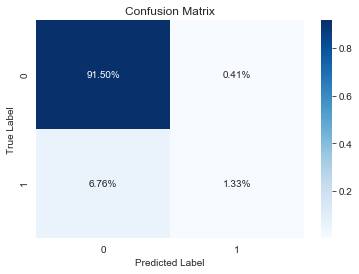

In [379]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(sg_confusion_matrix/np.sum(sg_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [64]:
sgd_dec = sgd.decision_function(X_test)

In [63]:
import numpy as np
from sklearn.metrics import roc_auc_score
sgd_roc_auc = roc_auc_score(y_test, sgd_y_pred)
sgd_roc_auc

#This is a terrible AUC score!

0.5

Test AUC: 0.8109557974685111


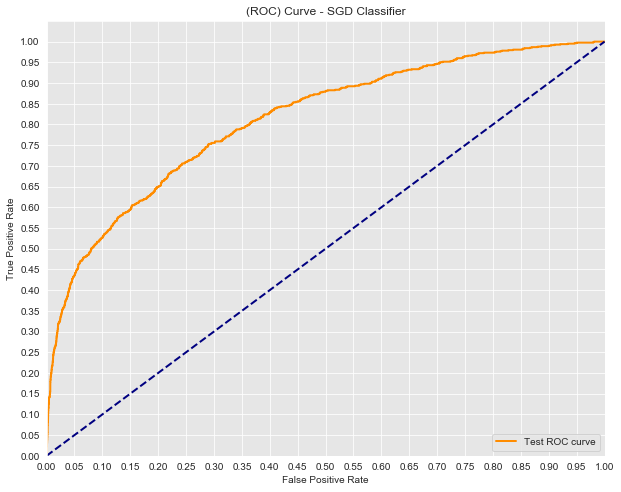

In [66]:
#AUC/ROC Curve

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, sgd_dec)

print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve - SGD Classifier')
plt.legend(loc='lower right')
plt.show()

# **Random Forest**

Class Imbalance: To overcome this issue, we used repeated random sub-sampling. Initially, we construct the testing data and the NoS training data sub-samples. For each disease, we train NoS classifiers and test all of them on the same data set. The final labels of the testing data are computed using a majority voting scheme.

In [256]:
from sklearn.ensemble import RandomForestClassifier

#add bag of trees?
#add OHE

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=None, max_features='auto', n_estimators=10, class_weight="balanced"))])


rf_pipeline.fit(X_train, y_train) 

rf_y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))

rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

[[9264   78]
 [ 646  217]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9342
           1       0.74      0.25      0.37       863

    accuracy                           0.93     10205
   macro avg       0.84      0.62      0.67     10205
weighted avg       0.92      0.93      0.91     10205



Text(0.5, 1, 'Confusion Matrix')

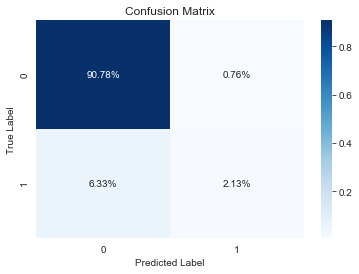

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

#shows percent data represented in each quadrant

sns.heatmap(rf_confusion_matrix/np.sum(rf_confusion_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [339]:
feature_names_cat = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_features)

In [340]:
feature_names_cat

array(['Postal_AK', 'Postal_AL', 'Postal_AR', 'Postal_AS', 'Postal_AZ',
       'Postal_CA', 'Postal_CO', 'Postal_CT', 'Postal_DC', 'Postal_DE',
       'Postal_FL', 'Postal_GA', 'Postal_GU', 'Postal_HI', 'Postal_IA',
       'Postal_ID', 'Postal_IL', 'Postal_IN', 'Postal_KS', 'Postal_KY',
       'Postal_LA', 'Postal_MA', 'Postal_MD', 'Postal_ME', 'Postal_MI',
       'Postal_MN', 'Postal_MO', 'Postal_MP', 'Postal_MS', 'Postal_MT',
       'Postal_NC', 'Postal_ND', 'Postal_NE', 'Postal_NH', 'Postal_NJ',
       'Postal_NM', 'Postal_NV', 'Postal_NY', 'Postal_OH', 'Postal_OK',
       'Postal_OR', 'Postal_PA', 'Postal_PR', 'Postal_RI', 'Postal_SC',
       'Postal_SD', 'Postal_TN', 'Postal_TX', 'Postal_UT', 'Postal_VA',
       'Postal_VI', 'Postal_VT', 'Postal_WA', 'Postal_WI', 'Postal_WV',
       'Postal_WY', 'dominant_topic_0', 'dominant_topic_1',
       'dominant_topic_2', 'dominant_topic_3', 'dominant_topic_4',
       'dominant_topic_5', 'dominant_topic_6', 'dominant_topic_7',
       'domina

In [264]:
importances = rf_pipeline.steps[1][1].feature_importances_
len(importances)

148

In [265]:
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

In [266]:
new_indices

array([  1,   0,  65,  71,  64, 136, 144, 141, 143, 140])

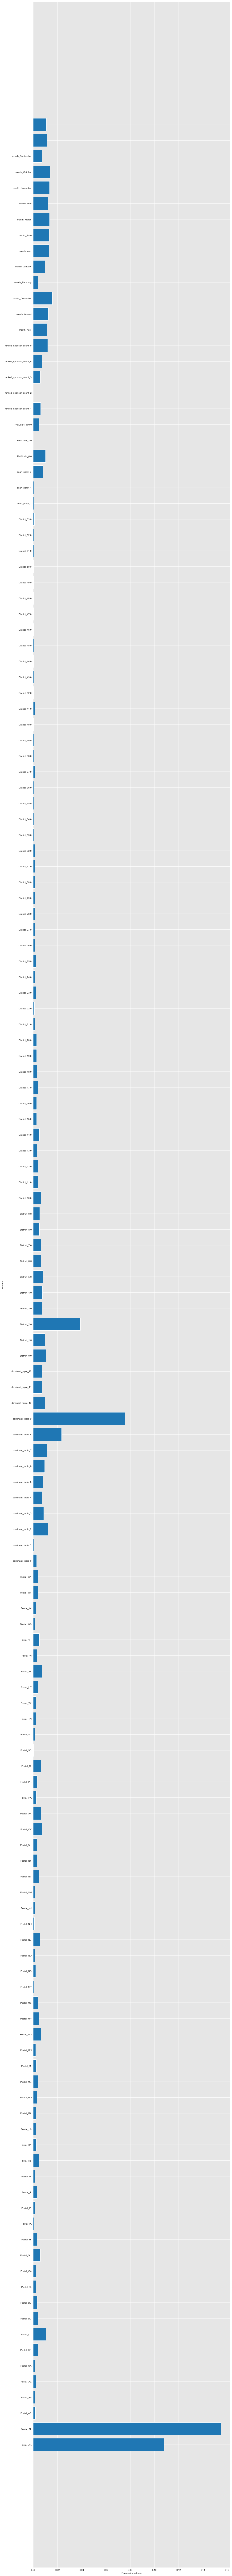

In [338]:
import matplotlib.pyplot as plt

def plot_feature_importances(model):
    
#     n_features = importances.shape
    
    plt.figure(figsize=(15,200))
    plt.barh(range(148), importances, align='center') 
    
    plt.yticks(np.arange(148), feature_names_cat) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(rf_pipeline)

In [113]:
import numpy as np
from sklearn.metrics import roc_auc_score
rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
rf_roc_auc

#This is a medium AUC score!

0.6294683801174236

**FINAL MODEL**

**Further Evaluation**:
- Classification Report
- Confusion Matrix
- ROC/AUC

https://www.kaggle.com/selener/multi-class-text-classification-tfidf

# Comparing all Models:

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:

mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc